## Forecasting experiments for NREL Oahu Dataset


## Install Libs


In [1]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS
!pip3 install -U git+https://github.com/cseveriano/spatio-temporal-forecasting
!pip3 install -U git+https://github.com/cseveriano/evolving_clustering
!pip3 install -U git+https://github.com/cseveriano/fts2image
!pip3 install -U hyperopt

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-edquhwgh
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-edquhwgh
  Created wheel for pyFTS: filename=pyFTS-1.6-cp36-none-any.whl size=210255 sha256=ea2fa718b1e2791083d0047d380252df55f10bd65f295cf66bb43d69eb6a8530
  Stored in directory: /tmp/pip-ephem-wheel-cache-wvjqbjkg/wheels/e7/32/a9/230470113df5a73242a5a6d05671cb646db97abf14bbce2644
Successfully built pyFTS
  Cloning https://github.com/cseveriano/spatio-temporal-forecasting to /tmp/pip-req-build-u0e4j8u8
  Running command git clone -q https://github.com/cseveriano/spatio-temporal-forecasting /tmp/pip-req-build-u0e4j8u8
  Created wheel for spatio-temporal-forecasting: filename=spatio_temporal_forecasting-1.0-cp36-none-any.whl size=55634 sha256=f41e3e95f1ce053787e4b0cb43794d40310c70b04572c7db8e4d281b6c25bdc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-g_ruv7ej/wheels/d2/1f/6f/439795864246039ef36c6a3c88edf7935c803c2cf97133066a
Succes

In [2]:
from google.colab import files

## Aux Functions

In [3]:
import datetime

def getRollingWindow(index):
    pivot = index
    train_start = pivot.strftime('%Y-%m-%d')
    pivot = pivot + datetime.timedelta(days=20)
    train_end = pivot.strftime('%Y-%m-%d')

    pivot = pivot + datetime.timedelta(days=1)
    validation_start = pivot.strftime('%Y-%m-%d')
    pivot = pivot + datetime.timedelta(days=6)
    validation_end = pivot.strftime('%Y-%m-%d')

    pivot = pivot + datetime.timedelta(days=1)
    test_start = pivot.strftime('%Y-%m-%d')
    pivot = pivot + datetime.timedelta(days=6)
    test_end = pivot.strftime('%Y-%m-%d')
    
    return train_start, train_end, validation_start, validation_end, test_start, test_end

In [21]:
from pyFTS.benchmarks import Measures
from spatiotemporal.util import benchmarks, metrics
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from scipy import stats


def residual_analysis(residuals, resid_len=1000):

  residuals = residuals[:resid_len]
  x = np.zeros((len(residuals)))
  
  f1 = plt.figure(1)
  plt.plot(x,residuals,'-', color = 'black', ms=4, lw=1, alpha=1, linewidth=1.5)
  plt.tick_params(labelsize=15)

  f2 = plt.figure(2)
  plt.hist(residuals, bins='auto', color='black')
  plt.tick_params(labelsize=15)

  f3 = plt.figure(3)
  plot_acf(residuals, plt.gca(), color='black', )
  plt.tick_params(labelsize=15)

  f4 = plt.figure(4)
  stats.probplot(np.reshape(residuals, (-1)), dist=stats.norm, plot=plt)
  plt.tick_params(labelsize=15)
  plt.show()

def calculate_rolling_error(cv_name, df, forecasts, order):
    cv_results = pd.DataFrame(columns=['Split', 'RMSE', 'SMAPE', 'nRMSE'])

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    residuals = []

    for i in np.arange(len(forecasts)):

        train_start, train_end, validation_start, validation_end, test_start, test_end = getRollingWindow(index)
        test = df[test_start : test_end]
    
        yhat = forecasts[i]
        
        residuals.extend(np.nanmean(test.iloc[order:].values - yhat[:-1], axis=1))

        rmse = Measures.rmse(test.iloc[order:], yhat[:-1])
        
        smape = Measures.smape(test.iloc[order:], yhat[:-1])

        nrmse = metrics.normalized_rmse(test.iloc[order:], yhat[:-1])
        
        res = {'Split' : index.strftime('%Y-%m-%d') ,'RMSE' : rmse, 'SMAPE' : smape, 'nRMSE' : nrmse}
        cv_results = cv_results.append(res, ignore_index=True)
        cv_results.to_csv(cv_name+".csv")        

        index = index + datetime.timedelta(days=7)

    residual_analysis(np.array(residuals).astype(np.float))

    return cv_results

In [7]:
from spatiotemporal.test import methods_space_oahu as ms
from spatiotemporal.util import parameter_tuning, sampling
from spatiotemporal.util import experiments as ex
from sklearn.metrics import mean_squared_error
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt import space_eval
import traceback
from . import sampling
import pickle

def calculate_error(loss_function, test_df, forecast, offset):
    error = loss_function(test_df.iloc[(offset):], forecast)
    print("Error : "+str(error))
    return error

def method_optimize(experiment, forecast_method, train_df, test_df, space, loss_function, max_evals):
    def objective(params):
        print(params)
        try:
            _output = list(params['output'])
            forecast = forecast_method(train_df, test_df, params)
            _step = params.get('step', 1)
            offset = params['order'] + _step - 1
            error = calculate_error(loss_function, test_df[_output], forecast, offset)
        except Exception:
            traceback.print_exc()
            error = 1000
        return {'loss': error, 'status': STATUS_OK}

    print("Running experiment: " + experiment)
    trials = Trials()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
    print('best parameters: ')
    print(space_eval(space, best))

    pickle.dump(best, open("best_" + experiment + ".pkl", "wb"))
    pickle.dump(trials, open("trials_" + experiment + ".pkl", "wb"))


def run_search(methods, data, train, loss_function, max_evals=100, resample=None):

    if resample:
        data = sampling.resample_data(data, resample)

    train_df, test_df = sampling.train_test_split(data, train)

    for experiment, method, space in methods:
        method_optimize(experiment, method, train_df, test_df, space, loss_function, max_evals)

## Load Dataset

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.metrics import mean_squared_error

In [51]:
import pandas as pd

def normalize(df):
    mindf = df.min()
    maxdf = df.max()
    return (df-mindf)/(maxdf-mindf)

df = pd.read_csv('https://query.data.world/s/wo5wryokqyg5uvbfqqij2mucgwly5u',  parse_dates=['datetime'], index_col=0)

df = normalize(df)

# Split data
#interval = ((df.index >= '2010-06') & (df.index < '2011-06'))
interval = ((df.index >= '2010-06') & (df.index < '2010-08'))
df = df.loc[interval]

along_wind_distances = ['DHHL_4','DHHL_3','DHHL_5','DHHL_10','DHHL_2','DHHL_9','DHHL_7']

exp_step = 8
multistep_mode = 'recursive'

## Data Analysis

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries, window=12):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')


In [ ]:
adf_test(df_ssa_residual.iloc[:810].DH3)

In [ ]:
kpss_test(df_ssa_residual.iloc[:810].DH3)

## Forecasting Methods

### Persistence

In [ ]:
def persistence_forecast(train, test, step):
    predictions = []
    
    for t in np.arange(0,len(test), step):
        yhat = [test.iloc[t]]  * step
        predictions.extend(yhat)
        
    return predictions

In [ ]:
step = 1
persistence_order = 1

forecast = persistence_forecast(train_df, test_df,step)

In [ ]:
calculate_rmse(test_df, forecast, persistence_order, step)

### VAR

In [39]:
from statsmodels.tsa.api import VAR, DynamicVAR

In [12]:
def evaluate_VAR_models(test_name, train, validation,target, maxlags_list):
    var_results = pd.DataFrame(columns=['Order','RMSE'])
    best_score, best_cfg, best_model = float("inf"), None, None
    
    for lgs in maxlags_list:
        model = VAR(train)
        results = model.fit(maxlags=lgs, ic='aic')
        
        order = results.k_ar
        forecast = []

        for i in range(len(validation)-order) :
            forecast.extend(results.forecast(validation.values[i:i+order],1))

        forecast_df = pd.DataFrame(columns=validation.columns, data=forecast)
        rmse = Measures.rmse(validation[target].iloc[order:], forecast_df[target].values)

        if rmse < best_score:
            best_score, best_cfg, best_model = rmse, order, results

        res = {'Order' : str(order) ,'RMSE' : rmse}
        print('VAR (%s)  RMSE=%.3f' % (str(order),rmse))
        var_results = var_results.append(res, ignore_index=True)
        var_results.to_csv(test_name+".csv")
        
    print('Best VAR(%s) RMSE=%.3f' % (best_cfg, best_score))
    return best_model

In [17]:
def var_forecast(train, test, order, step):
    model = VAR(train.values)
    results = model.fit(maxlags=order)
    lag_order = results.k_ar
    print("Lag order:" + str(lag_order))
    forecast = []

    for i in np.arange(len(test)-lag_order+1) :
      input = test.values[i:i+lag_order].copy()
      for s in np.arange(step):
        f = results.forecast(input,1)
        input = np.append(input[1:], f, axis=0)
      forecast.extend(f)

    forecast_df = pd.DataFrame(columns=test.columns, data=forecast)
    return forecast_df.values

In [14]:
def rolling_cv_var(df, order, step):
    forecasts = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, validation_start, validation_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        validation = df[validation_start : validation_end]
        test = df[test_start : test_end]
    
        # Concat train & validation for test
        train = train.append(validation)
        yhat = var_forecast(train, test, order, step)
        
        forecasts.append(yhat)

    return forecasts

Index:  2010-06-01
Lag order:4
Index:  2010-06-08
Lag order:4
Index:  2010-06-15
Lag order:4
Index:  2010-06-22
Lag order:4
Index:  2010-06-29
Lag order:4


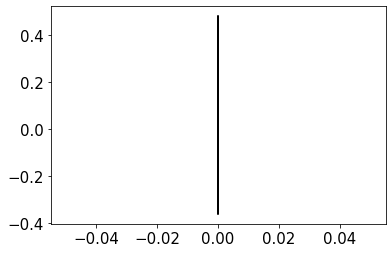

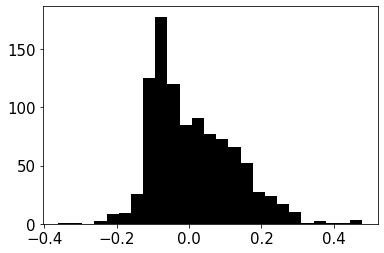

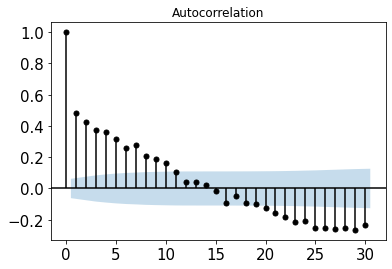

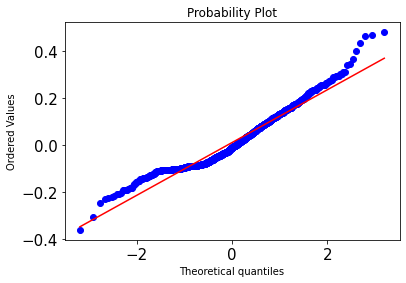

In [52]:
step = exp_step
order = 4
exp_name = "BENCHMARK-2_1-VAR"
forecasts = rolling_cv_var(df, order, step)
var_results_df = calculate_rolling_error(exp_name, df, forecasts, order)

In [ ]:
files.download('BENCHMARK-2_1-VAR.csv')

### e-MVFTS

In [41]:
from spatiotemporal.models.clusteredmvfts.fts import evolvingclusterfts

In [42]:
def evolvingfts_forecast(train_df, test_df, _order, train_model=True):

    _variance_limit = 0.001
    _defuzzy = 'weighted'
    _t_norm = 'threshold'
    _membership_threshold = 0.6
    _order = 2
    _step = 1

    model = evolvingclusterfts.EvolvingClusterFTS(variance_limit=_variance_limit, defuzzy=_defuzzy, t_norm=_t_norm,
                                                  membership_threshold=_membership_threshold)

    model.fit(train_df.values, order=_order, verbose=False)

    forecast = model.predict(test_df.values, steps_ahead=_step)

    forecast_df = pd.DataFrame(data=forecast, columns=test_df.columns)
    return forecast_df.values

In [43]:
def rolling_cv_evolving(df, order, step):
    forecasts = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    first_time = True

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, validation_start, validation_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        validation = df[validation_start : validation_end]
        test = df[test_start : test_end]
    
        # Concat train & validation for test
        train = train.append(validation)
        yhat = list(evolvingfts_forecast(train, test, order, train_model=first_time))
        #yhat.append(yhat[-1]) #para manter o formato do vetor de metricas
        forecasts.append(yhat)

        first_time = False

    return forecasts

Index:  2010-06-01
Index:  2010-06-08
Index:  2010-06-15
Index:  2010-06-22
Index:  2010-06-29


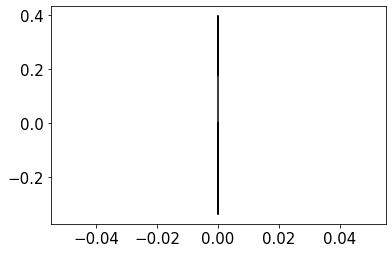

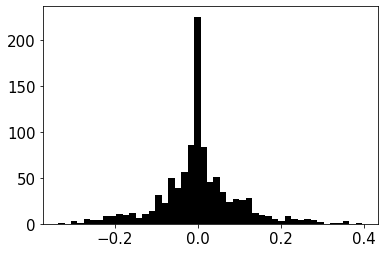

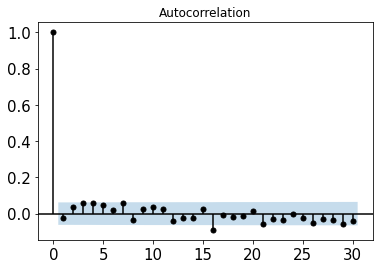

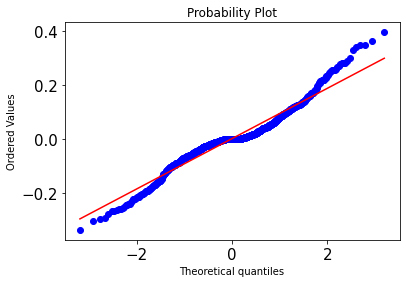

In [53]:
step = 1
evolfts_order = 2
exp_name = "BENCHMARK-2_1-EVOLVING"
forecasts = rolling_cv_evolving(df, evolfts_order, step)
evolving_results_df = calculate_rolling_error(exp_name, df, forecasts, evolfts_order)

In [ ]:
files.download('BENCHMARK-2_1-EVOLVING.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### MLP

In [45]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization

In [29]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### MLP Parameter Tuning

In [ ]:
from spatiotemporal.test import methods_space_oahu as ms
from spatiotemporal.util import parameter_tuning, sampling
from spatiotemporal.util import experiments as ex
from sklearn.metrics import mean_squared_error
from hyperopt import hp
import numpy as np

In [ ]:
mlp_space = {'choice':

   hp.choice('num_layers',
             [
                 {'layers': 'two',
                 },

                 {'layers': 'three',

                   'units3': hp.choice('units3', [8, 16, 64, 128, 256, 512]),
                   'dropout3': hp.choice('dropout3', [0, 0.25, 0.5, 0.75])
                  }

             ]),
   'units1': hp.choice('units1', [8, 16, 64, 128, 256, 512]),
   'units2': hp.choice('units2', [8, 16, 64, 128, 256, 512]),

   'dropout1': hp.choice('dropout1', [0, 0.25, 0.5, 0.75]),
   'dropout2': hp.choice('dropout2', [0, 0.25, 0.5, 0.75]),

   'batch_size': hp.choice('batch_size', [28, 64, 128, 256, 512]),
   'order': hp.choice('order', [1, 2, 3]),
   'input': hp.choice('input', [along_wind_distances]),
   'output': hp.choice('output', [along_wind_distances]),
   'epochs': hp.choice('epochs', [100, 200, 300])}


In [ ]:
def mlp_tuning(train_df, test_df, params):
    _input = list(params['input'])
    _nlags = params['order']
    _epochs = params['epochs']
    _batch_size = params['batch_size']
    nfeat = len(_input)
    nsteps = params.get('step',1)
    nobs = _nlags * nfeat

    output_index = -nfeat*nsteps

    train_reshaped_df = series_to_supervised(train_df[_input], n_in=_nlags, n_out=nsteps)
    train_X, train_Y = train_reshaped_df.iloc[:, :nobs].values, train_reshaped_df.iloc[:, output_index:].values

    test_reshaped_df = series_to_supervised(test_df[_input], n_in=_nlags, n_out=nsteps)
    test_X, test_Y = test_reshaped_df.iloc[:, :nobs].values, test_reshaped_df.iloc[:, output_index:].values

    # design network
    model = Sequential()
    model.add(Dense(params['units1'], input_dim=train_X.shape[1], activation='relu'))
    model.add(Dropout(params['dropout1']))
    model.add(BatchNormalization())

    model.add(Dense(params['units2'], activation='relu'))
    model.add(Dropout(params['dropout2']))
    model.add(BatchNormalization())

    if params['choice']['layers'] == 'three':
        model.add(Dense(params['choice']['units3'], activation='relu'))
        model.add(Dropout(params['choice']['dropout3']))
        model.add(BatchNormalization())

    model.add(Dense(train_Y.shape[1], activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')

    # includes the call back object
    model.fit(train_X, train_Y, epochs=_epochs, batch_size=_batch_size, verbose=False, shuffle=False)

    # predict the test set
    forecast = model.predict(test_X, verbose=False)

    return forecast


In [ ]:
methods = []
methods.append(("EXP_WIND_MLP", mlp_tuning, mlp_space))

In [ ]:
train_split = 0.6
run_search(methods, df, train_split, Measures.rmse, max_evals=100, resample=None)

#### MLP Forecasting

In [46]:
def mlp_multi_forecast(train_df, test_df, _order, _steps):

    
    nfeat = len(train_df.columns)
    nlags = _order
    nsteps = _steps
    nobs = nlags * nfeat

    output_index = -nfeat*nsteps

    train_reshaped_df = series_to_supervised(train_df, n_in=nlags, n_out=nsteps)
    train_X, train_Y = train_reshaped_df.iloc[:, :nobs].values, train_reshaped_df.iloc[:, output_index:].values

    test_reshaped_df = series_to_supervised(test_df, n_in=nlags, n_out=nsteps)
    test_X, test_Y = test_reshaped_df.iloc[:, :nobs].values, test_reshaped_df.iloc[:, output_index:].values
    
    # design network
    model = designMLPNetwork(train_X.shape[1], train_Y.shape[1])
    
    # fit network
    model.fit(train_X, train_Y, epochs=500, batch_size=1000, verbose=False, shuffle=False)
    
    forecast = model.predict(test_X)
    
#    fcst = [f[0] for f in forecast]
    fcst = forecast
    return fcst

In [47]:
def designMLPNetwork(input_shape, output_shape):
    params = {'batch_size': 128, 'choice': {'layers': 'two'}, 'dropout1': 0, 'dropout2': 0.25, 'epochs': 300, 
              'input': along_wind_distances, 'order': 3, 'output': along_wind_distances, 
              'units1': 128, 'units2': 256}
    model = Sequential()
    model.add(Dense(params['units1'], input_dim=input_shape, activation='relu'))
    model.add(Dropout(params['dropout1']))
    model.add(BatchNormalization())

    model.add(Dense(params['units2'], activation='relu'))
    model.add(Dropout(params['dropout2']))
    model.add(BatchNormalization())

    if params['choice']['layers'] == 'three':
        model.add(Dense(params['choice']['units3'], activation='relu'))
        model.add(Dropout(params['choice']['dropout3']))
        model.add(BatchNormalization())

    model.add(Dense(output_shape, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')

    return model

In [48]:
def rolling_cv_mlp(df, order, step):
    
    forecasts = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, validation_start, validation_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        validation = df[validation_start : validation_end]
        test = df[test_start : test_end]

        # Perform grid search
#        (_neurons, _order,epochs) = evaluate_multivariate_mlp_models("nested_eval_mlp_multi_oahu", train[neighbor_stations_90], validation[neighbor_stations_90], neurons_list, order_list, epochs_list)

        # Concat train & validation for test
        train = train.append(validation)

        # Perform forecast
        yhat = list(mlp_multi_forecast(train, test, order, 1))
        
        yhat.append(yhat[-1]) #para manter o formato do vetor de metricas
        
        forecasts.append(yhat)

    return forecasts

Index:  2010-06-01
Index:  2010-06-08
Index:  2010-06-15
Index:  2010-06-22
Index:  2010-06-29


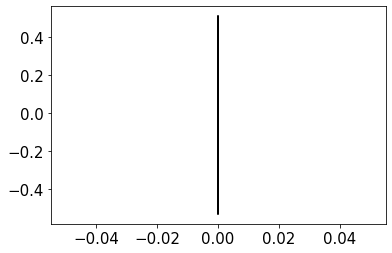

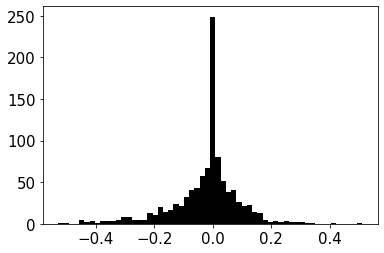

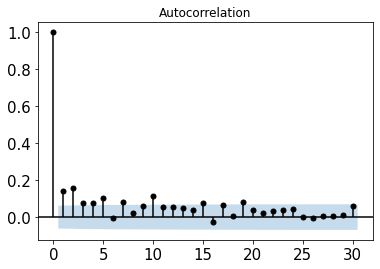

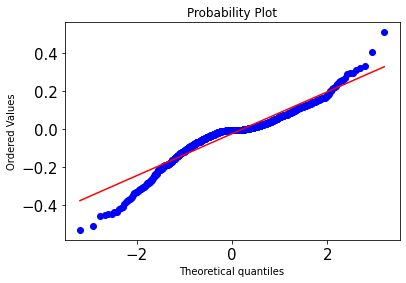

In [49]:
step = 1
order = 2
exp_name = "BENCHMARK-2_1-MLP"
forecasts = rolling_cv_mlp(df, order, step)
mlp_results_df = calculate_rolling_error(exp_name, df, forecasts, order)

In [ ]:
files.download('BENCHMARK-2_1-MLP.csv')

### Granular FTS

In [34]:
from pyFTS.models.multivariate import granular
from pyFTS.partitioners import Grid, Entropy
from pyFTS.models.multivariate import variable
from pyFTS.common import Membership
from pyFTS.partitioners import Grid, Entropy

#### Granular Parameter Tuning

In [ ]:
granular_space = {
    'npartitions': hp.choice('npartitions', [100, 150, 200]),
    'order': hp.choice('order', [1, 2]),
    'knn': hp.choice('knn', [1, 2, 3, 4, 5]),
    'alpha_cut': hp.choice('alpha_cut', [0, 0.1, 0.2, 0.3]),
   'input': hp.choice('input', [['DHHL_4','DHHL_3','DHHL_5']]),
   'output': hp.choice('output', [['DHHL_4','DHHL_3','DHHL_5']])}

In [ ]:
def granular_tuning(train_df, test_df, params):
    _input = list(params['input'])
    _output = list(params['output'])
    _npartitions = params['npartitions']
    _order = params['order']
    _knn = params['knn']
    _alpha_cut = params['alpha_cut']
    _step = params.get('step',1)

    ## create explanatory variables
    exp_variables = []
    for vc in _input:
        exp_variables.append(variable.Variable(vc, data_label=vc, alias=vc,
                                               npart=_npartitions, func=Membership.trimf,
                                               data=train_df, alpha_cut=_alpha_cut))
    model = granular.GranularWMVFTS(explanatory_variables=exp_variables, target_variable=exp_variables[0], order=_order,
                                    knn=_knn)
    model.fit(train_df[_input], num_batches=1)

    if _step > 1:
        forecast = pd.DataFrame(columns=test_df.columns)
        length = len(test_df.index)

        for k in range(0,(length -(_order + _step - 1))):
            fcst = model.predict(test_df[_input], type='multivariate', start_at=k, steps_ahead=_step)
            forecast = forecast.append(fcst.tail(1))
    else:
        forecast = model.predict(test_df[_input], type='multivariate')

    return forecast[_output].values


In [ ]:
methods = []
methods.append(("EXP_WIND_GRANULAR", granular_tuning, granular_space))

In [ ]:
train_split = 0.6
run_search(methods, df, train_split, Measures.rmse, max_evals=10, resample=None)

#### Granular Forecasting

In [35]:
def granular_forecast(train_df, test_df, order, step):
    params = {'alpha_cut': 0.2, 'input': ('DHHL_4', 'DHHL_3', 'DHHL_5'), 'knn': 5, 'npartitions': 150, 
              'order': 2, 'output': ('DHHL_4', 'DHHL_3', 'DHHL_5')}

    _input = list(params['input'])
    _output = list(params['output'])
    _npartitions = params['npartitions']
    _knn = params['knn']
    _alpha_cut = params['alpha_cut']
    _order = order
    _step = step

    ## create explanatory variables
    exp_variables = []
    for vc in _input:
        exp_variables.append(variable.Variable(vc, data_label=vc, alias=vc,
                                               npart=_npartitions, func=Membership.trimf,
                                               data=train_df, alpha_cut=_alpha_cut))
    model = granular.GranularWMVFTS(explanatory_variables=exp_variables, target_variable=exp_variables[0], order=_order,
                                    knn=_knn)
    model.fit(train_df[_input], num_batches=1)

    if _step > 1:
        forecast = pd.DataFrame(columns=test_df.columns)
        length = len(test_df.index)

        for k in range(0,(length -(_order + _step - 1))):
            fcst = model.predict(test_df[_input], type='multivariate', start_at=k, steps_ahead=_step)
            forecast = forecast.append(fcst.tail(1))
    else:
        forecast = model.predict(test_df[_input], type='multivariate')

    return forecast[_output].values


In [36]:
def rolling_cv_granular(df, order, step):
    
    forecasts = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, validation_start, validation_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        validation = df[validation_start : validation_end]
        test = df[test_start : test_end]

        # Perform grid search
#        (_neurons, _order,epochs) = evaluate_multivariate_granular_models("nested_eval_mlp_multi_oahu", train[neighbor_stations_90], validation[neighbor_stations_90], neurons_list, order_list, epochs_list)

        # Concat train & validation for test
        train = train.append(validation)

        # Perform forecast
        yhat = list(granular_forecast(train, test, order, step))
        
        yhat.append(yhat[-1]) #para manter o formato do vetor de metricas
        
        forecasts.append(yhat)

    return forecasts

Index:  2010-06-01
Index:  2010-06-08
Index:  2010-06-15
Index:  2010-06-22
Index:  2010-06-29


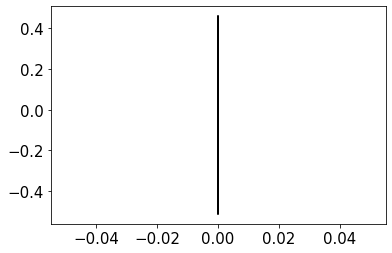

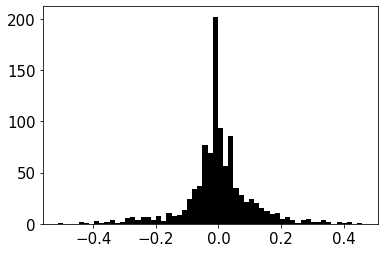

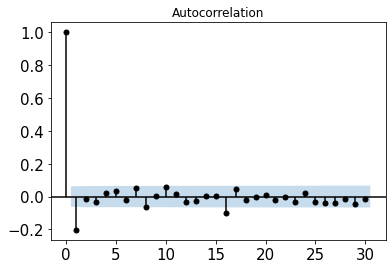

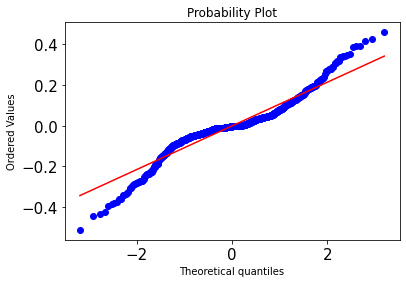

In [50]:
step = 1
order = 2
exp_name = "BENCHMARK-2_1-GRANULAR"
forecasts = rolling_cv_granular(df, order, step)
granular_results_df = calculate_rolling_error(exp_name, df[['DHHL_4', 'DHHL_3', 'DHHL_5']], forecasts, order)

In [ ]:
files.download('BENCHMARK-2_1-GRANULAR.csv')

## Result Analysis

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
files.upload()

Saving BENCHMARK-2_1-EVOLVING.csv to BENCHMARK-2_1-EVOLVING.csv
Saving BENCHMARK-2_1-GRANULAR.csv to BENCHMARK-2_1-GRANULAR.csv
Saving BENCHMARK-2_1-MLP.csv to BENCHMARK-2_1-MLP.csv
Saving BENCHMARK-2_1-VAR.csv to BENCHMARK-2_1-VAR.csv


{'BENCHMARK-2_1-EVOLVING.csv': b',Split,RMSE,SMAPE,nRMSE\n0,2010-06-01,0.09258884847369839,14.897027559720733,0.22294401180578038\n1,2010-06-08,0.11747100028169381,18.833710306867488,0.2942333407151115\n2,2010-06-15,0.11156106547486072,21.40256700109298,0.30910654061585646\n3,2010-06-22,0.10701320979790738,20.670241602242566,0.26392702222856756\n4,2010-06-29,0.1155634878948496,20.300413915176343,0.2773097365787678\n5,2010-07-06,0.10597751571637308,19.146774952106206,0.2559065512176121\n6,2010-07-13,0.10458797830871686,21.263458215595477,0.24867878804946422\n7,2010-07-20,0.09983009277216814,23.124078222081902,0.24183191046009164\n8,2010-07-27,0.09483474531101964,23.553807477713438,0.22235391621875733\n9,2010-08-03,0.1091188481015858,22.02565894952924,0.2777734384416948\n10,2010-08-10,0.10786221216825514,26.5614213519276,0.27858838832276617\n11,2010-08-17,0.10196359137585724,25.406094342886682,0.265760836143738\n12,2010-08-24,0.09224474469558121,17.732749471040314,0.2526521225230905\n13,

In [ ]:
def createBoxplot(filename, data, xticklabels, ylabel):
    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the boxplot
    bp = ax.boxplot(data, patch_artist=True)
    
    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='#7570b3', linewidth=2)
        # change fill color
        box.set( facecolor = '#AACCFF' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#FFE680', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)
    
    ## Custom x-axis labels
    ax.set_xticklabels(xticklabels)
    ax.set_ylabel(ylabel)
    plt.show()
    fig.savefig(filename, bbox_inches='tight')

In [15]:
step = "1"
var_results = pd.read_csv("BENCHMARK-2_1-"+step+"-VAR.csv")
evolving_results = pd.read_csv("BENCHMARK-2_1-"+step+"-EVOLVING.csv")
mlp_results = pd.read_csv("BENCHMARK-2_1-"+step+"-MLP.csv")
granular_results = pd.read_csv("BENCHMARK-2_1-"+step+"-GRANULAR.csv")

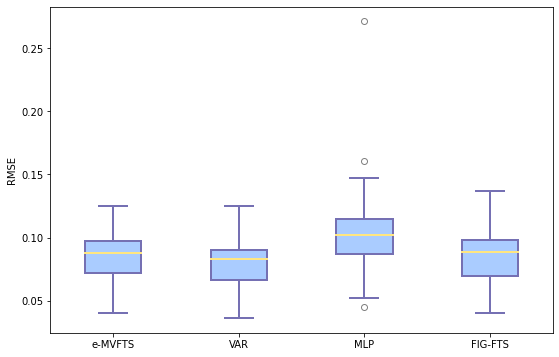

In [ ]:
metric = 'RMSE'
results_data = [evolving_results[metric],var_results[metric], mlp_results[metric], granular_results[metric]]
xticks = ['e-MVFTS','VAR','MLP','FIG-FTS']

ylab = 'RMSE'
createBoxplot("e-mvfts_boxplot_rmse_solar", results_data, xticks, ylab)

In [ ]:
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
metric = 'RMSE'
rmse_df = pd.DataFrame(columns=['e-MVFTS','VAR','MLP','FIG-FTS'])

rmse_df["e-MVFTS"] = evolving_results[metric]
rmse_df["VAR"] = var_results[metric]
rmse_df["MLP"] = mlp_results[metric]
rmse_df["FIG-FTS"] = granular_results[metric]

In [ ]:
rmse_df.std()

In [ ]:
metric = 'SMAPE'
results_data = [evolving_results[metric],var_results[metric], mlp_results[metric], granular_results[metric]]
xticks = ['e-MVFTS','VAR','MLP','FIG-FTS']

ylab = 'SMAPE'
createBoxplot("e-mvfts_boxplot_smape_solar", results_data, xticks, ylab)

In [ ]:
metric = 'SMAPE'
smape_df = pd.DataFrame(columns=['e-MVFTS','VAR','MLP','FIG-FTS'])

smape_df["e-MVFTS"] = evolving_results[metric]
smape_df["VAR"] = var_results[metric]
smape_df["MLP"] = mlp_results[metric]
smape_df["FIG-FTS"] = granular_results[metric]

In [ ]:
smape_df.std()

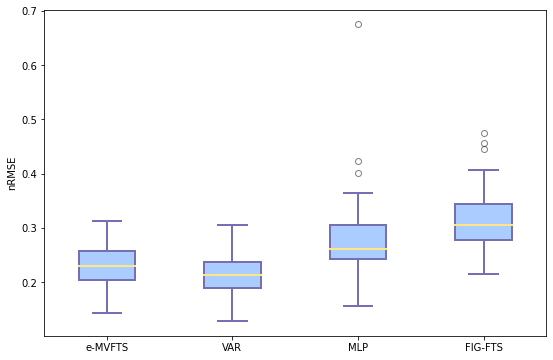

In [ ]:
metric = 'nRMSE'
results_data = [evolving_results[metric],var_results[metric], mlp_results[metric], granular_results[metric]]
xticks = ['e-MVFTS','VAR','MLP','FIG-FTS']

ylab = 'nRMSE'
createBoxplot("e-mvfts_boxplot_nrmse_solar", results_data, xticks, ylab)

In [ ]:
metric = 'nRMSE'
nrmse_df = pd.DataFrame(columns=['e-MVFTS','VAR','MLP','FIG-FTS'])

nrmse_df["e-MVFTS"] = evolving_results[metric]
nrmse_df["VAR"] = var_results[metric]
nrmse_df["MLP"] = mlp_results[metric]
nrmse_df["FIG-FTS"] = granular_results[metric]

In [ ]:
nrmse_df.std()

e-MVFTS   0.0395
VAR       0.0377
MLP       0.0812
FIG-FTS   0.0602
dtype: float64

In [17]:
def plot_error_evolution(metric):
  data = pd.DataFrame(columns=["VAR", "e-MVFTS", "MLP", "Granular"])

  data["VAR"] = var_results[metric]
  data["e-MVFTS"] = evolving_results[metric]
  data["MLP"] = mlp_results[metric]
  data["Granular"] = granular_results[metric]

  ax = data.plot(figsize=(18,6))
  ax.set(xlabel='Window', ylabel=metric)
  fig = ax.get_figure()
  #fig.savefig(path_images + exp_id + "_prequential.png")
      
  x = np.arange(len(data.columns.values))
  names = data.columns.values
  values = data.mean().values
  plt.figure(figsize=(5,6))
  plt.bar(x, values, align='center', alpha=0.5, width=0.9)
  plt.xticks(x, names)
  #plt.yticks(np.arange(0, 1.1, 0.1))
  plt.ylabel(metric)
  #plt.savefig(path_images + exp_id + "_bars.png")


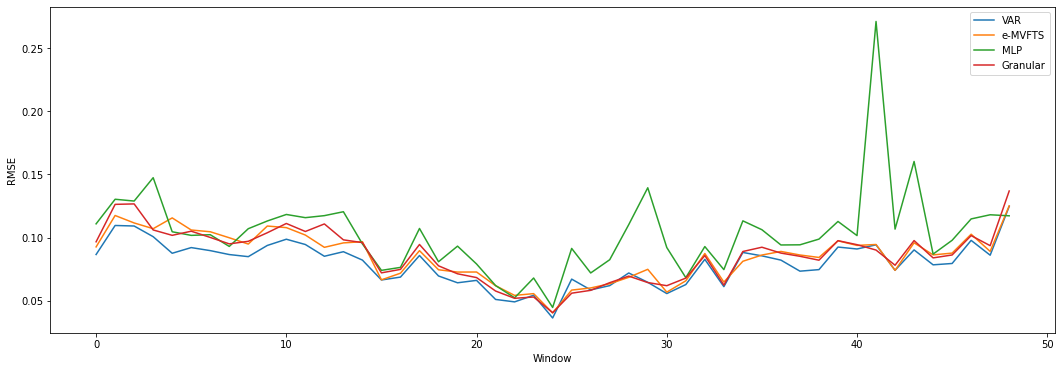

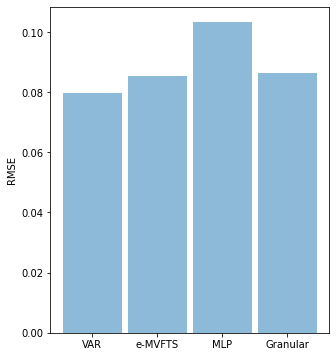

In [ ]:
plot_error_evolution("RMSE")

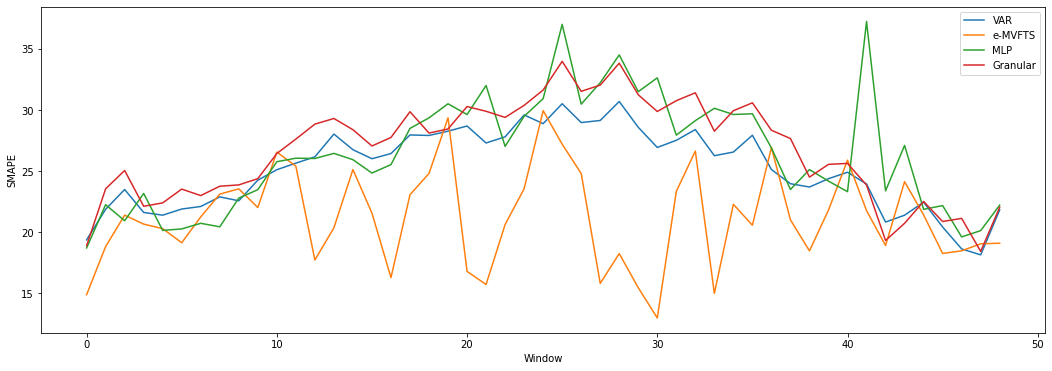

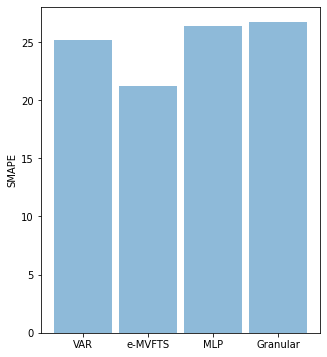

In [ ]:
plot_error_evolution("SMAPE")

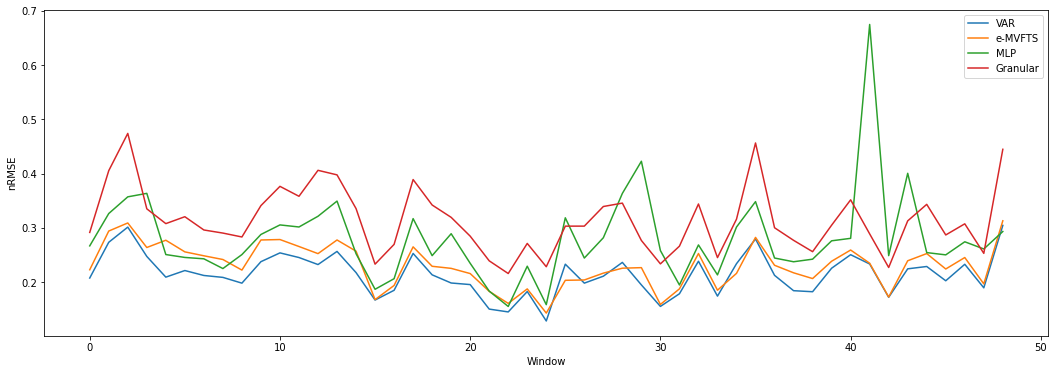

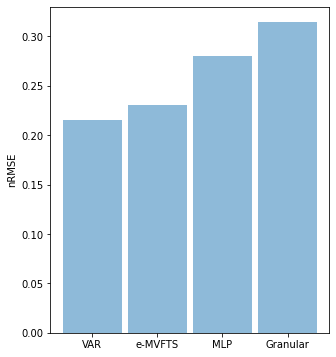

In [18]:
plot_error_evolution("nRMSE")

### Multistep Forecasting

In [7]:
files.upload()

Saving BENCHMARK-2_1-8-EVOLVING.csv to BENCHMARK-2_1-8-EVOLVING.csv
Saving BENCHMARK-2_1-8-GRANULAR.csv to BENCHMARK-2_1-8-GRANULAR.csv
Saving BENCHMARK-2_1-8-MLP.csv to BENCHMARK-2_1-8-MLP.csv
Saving BENCHMARK-2_1-8-VAR.csv to BENCHMARK-2_1-8-VAR.csv


{'BENCHMARK-2_1-8-EVOLVING.csv': b',Split,RMSE,SMAPE,nRMSE\n0,2010-06-01,0.2039445287380074,33.87448705846287,0.48638634825881577\n1,2010-06-08,0.23144213729110572,40.736968848698865,0.5736436683832971\n2,2010-06-15,0.2243007448823062,42.054513418711124,0.6159641563790097\n3,2010-06-22,0.21852940715614969,38.71318920323735,0.533717399898705\n4,2010-06-29,0.22580309401646798,40.26313954824173,0.5363178857761153\n5,2010-07-06,0.21248826723078276,38.436594702957635,0.5076286191254892\n6,2010-07-13,0.21959291457434515,38.13891384692345,0.5163351395621185\n7,2010-07-20,0.22342343209164486,40.90829568931424,0.5353022112724927\n8,2010-07-27,0.22225067943639717,41.63652401764464,0.5155899974163883\n9,2010-08-03,0.22235699313868262,41.6838439816342,0.560284092250235\n10,2010-08-10,0.20708047384909084,42.82722441505691,0.5292209444151132\n11,2010-08-17,0.20838731402850783,42.32363732126694,0.5379416789736388\n12,2010-08-24,0.21653705831929962,41.09165610406426,0.5871279566478111\n13,2010-08-31,0

In [8]:
def insert_multistep_error(method_name, step, error_df, metric, multistep_df):
  l = len(error_df.index)
  new_df = pd.DataFrame({"Method": l * [method_name], "Error": error_df[metric], "Step" : l * [step]}, columns=["Method", "Error", "Step"])
  return pd.concat([multistep_df,new_df])

In [9]:
multistep_df = pd.DataFrame(columns=["Method", "Error", "Step"])

metric = "nRMSE"

In [10]:
var_results = pd.read_csv("BENCHMARK-2_1-1-VAR.csv")
evolving_results = pd.read_csv("BENCHMARK-2_1-1-EVOLVING.csv")
mlp_results = pd.read_csv("BENCHMARK-2_1-1-MLP.csv")
granular_results = pd.read_csv("BENCHMARK-2_1-1-GRANULAR.csv")

multistep_df = insert_multistep_error("VAR", 1, var_results, metric, multistep_df)
multistep_df = insert_multistep_error("e-MVFTS", 1, evolving_results, metric, multistep_df)
multistep_df = insert_multistep_error("MLP", 1, mlp_results, metric, multistep_df)
multistep_df = insert_multistep_error("FIG-FTS", 1, granular_results, metric, multistep_df)

In [11]:
var_results = pd.read_csv("BENCHMARK-2_1-4-VAR.csv")
evolving_results = pd.read_csv("BENCHMARK-2_1-4-EVOLVING.csv")
mlp_results = pd.read_csv("BENCHMARK-2_1-4-MLP.csv")
granular_results = pd.read_csv("BENCHMARK-2_1-4-GRANULAR.csv")

multistep_df = insert_multistep_error("VAR", 4, var_results, metric, multistep_df)
multistep_df = insert_multistep_error("e-MVFTS", 4, evolving_results, metric, multistep_df)
multistep_df = insert_multistep_error("MLP", 4, mlp_results, metric, multistep_df)
multistep_df = insert_multistep_error("FIG-FTS", 4, granular_results, metric, multistep_df)

In [12]:
var_results = pd.read_csv("BENCHMARK-2_1-8-VAR.csv")
evolving_results = pd.read_csv("BENCHMARK-2_1-8-EVOLVING.csv")
mlp_results = pd.read_csv("BENCHMARK-2_1-8-MLP.csv")
granular_results = pd.read_csv("BENCHMARK-2_1-8-GRANULAR.csv")

multistep_df = insert_multistep_error("VAR", 8, var_results, metric, multistep_df)
multistep_df = insert_multistep_error("e-MVFTS", 8, evolving_results, metric, multistep_df)
multistep_df = insert_multistep_error("MLP", 8, mlp_results, metric, multistep_df)
multistep_df = insert_multistep_error("FIG-FTS", 8, granular_results, metric, multistep_df)

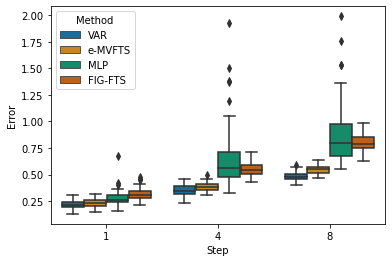

In [13]:
sns.boxplot(y='Error', x='Step', 
                 data=multistep_df, 
                 palette="colorblind",
                 hue='Method')